# MPAS-Ocean water mass analysis

## Ten-year averages (1947-1956, 1997-2006): All seasons

LR (`60to30E2r2`) and HR (`18to6v3`) CORE-forced 20-21st century simulations (Cycle 1).

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
from dateutil.parser import parse
from datetime import datetime

# Import modules from path
sys.path.append('../modules/')
import visualizationtools as viz
import watermasstransformation as wmt

# Set plot font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

## Load results

Define paths, parameters and load aggregated netCDF files. Files were produced using [watermasstransformation.py](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/modules/watermasstransformation.py).

In [2]:
# Results path
resultspath = '/pscratch/sd/b/bmoorema/results/wmtr/'
prefix, suffix = '20210421_sim7_CORE_', '.wmtrvars_19470101_20061201.nc'
meshes = ['EC30to60E2r2', 'oRRS18to6v3']

# Time ranges of interest
timeranges = [
    ('1947 Jan 1', '1956 Dec 31'),
    ('1997 Jan 1', '2006 Dec 31'),
]
timeranges = [[parse(t) for t in trange] for trange in timeranges]

# Load MPAS variables file
ds = {'tr': {mesh: xr.open_dataset(resultspath + prefix + mesh + suffix) for mesh in meshes}, 'fm': {}}

In [3]:
time = ds['tr'][meshes[0]].time
sigma = ds['tr'][meshes[0]].sigmaBins[:-1]
modewaterindices = {}
modewaterdefs = {
    'STMW': (26.1, 27),
    'SPMW': (27.2, 29),
}
for name in modewaterdefs:
    l, u = modewaterdefs[name]
    modewaterindices[name] = (sigma >= l) & (sigma <= u)

In [4]:
_, fluxdefs = wmt.load_variable_definitions(vardefsfile='../yaml/variable_definitions.yaml')

modewater = {mesh: {mw: {} for mw in modewaterdefs} for mesh in meshes}

# Loop through meshes
for mesh in meshes:
    
    # Calculate totals
    totals = {name: sum([ds['tr'][mesh][var] for var in fluxdefs[name]]) for name in ['heat', 'salt']}
    totals['total'] = totals['heat'] + totals['salt']
    ds['tr'][mesh] = ds['tr'][mesh].assign(totals)
    
    # Calculate formation
    variables = {}
    for name in ds['tr'][mesh]:
        fm = -ds['tr'][mesh][name].diff(dim='sigmaBins', label='lower')
        for mw in modewaterindices:
            for func in ('less', 'greater'):
                modewater[mesh][mw][func] = fm.where(getattr(np, func)(fm, 0)).sel(sigmaBins=modewaterindices[mw]).sum(dim='sigmaBins')
            modewater[mesh][mw]['net'] = modewater[mesh][mw]['less'] + modewater[mesh][mw]['greater']
        variables[name] = fm
    ds['fm'][mesh] = xr.Dataset(variables)

***

## Visualization

### Mode water definitions

I've adjusted the Howe and Czaja (2009) boundaries slightly to contain what appear to be the mode water regions of the MPAS LR and HR runs.

   - STMW (18$^{\circ}$ water): $26.1 < \sigma < 27$
   - SPMW: $\sigma > 27.2$

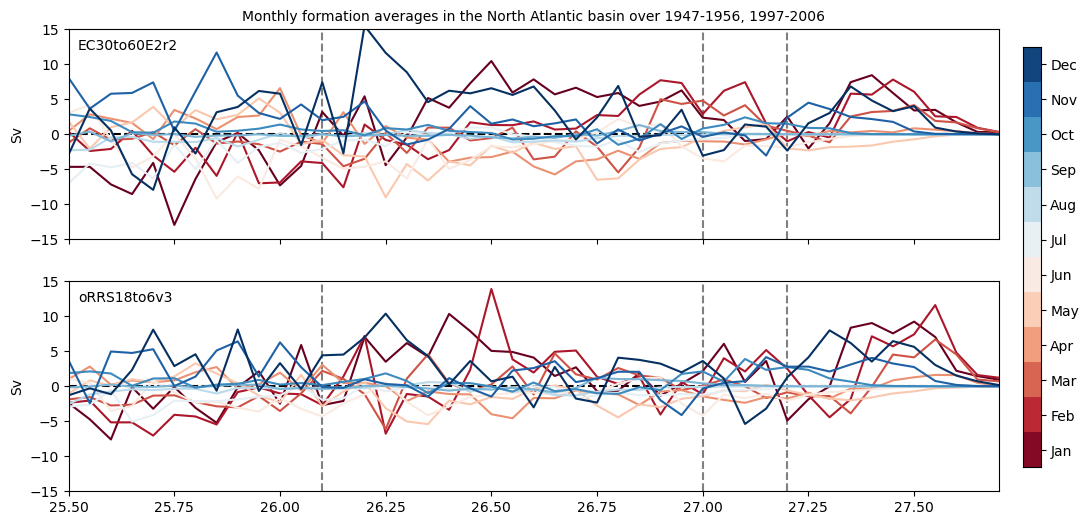

In [162]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
xlim, ylim = [25.5, 27.7], [-15, 15]
cmap = plt.get_cmap('RdBu')

for ax, mesh in zip(axs, meshes):

    ax.plot(xlim, [0, 0], 'k--')
    for sg in [26.1, 27, 27.2]:
        ax.plot([sg, sg], ylim, '--', color='gray')
    for month in range(1, 13):
        tindex = ds['fm'][mesh].time.dt.month == month
        fm = ds['fm'][mesh].total.sel(time=tindex, regionNames='North Atlantic Ocean').mean(dim='time')
        ax.plot(sigma, fm, color=cmap((month-1)/11), label=month)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('Sv')
    ax.text(0.01, 0.9, mesh, transform=ax.transAxes)

axs[0].xaxis.set_ticklabels('')
axs[0].set_title('Monthly formation averages in the North Atlantic basin over 1947-1956, 1997-2006')

# Make dummy colorbar
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar_data = np.arange(0, 1.1, 0.1)[:, None] * np.ones((1, 2))
cax.contourf([0, 1], cbar_data[:, 0], cbar_data, levels=np.linspace(0, 1, 13), cmap='RdBu')
cax.xaxis.set_ticks([])
cax.yaxis.set_ticks(np.linspace(0.04, 0.96, 12))
cax.yaxis.set_ticklabels([datetime(1, m, 1).strftime('%b') for m in range(1, 13)])
cax.yaxis.tick_right()

***

### Mode water formation

Functions

In [154]:
def plot_mw_ts(mwtype, cumulative=False, ylim=None):
    """
    """

    fig, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
    
    units = 'km$^3$' if cumulative else 'Sv'

    # Loop through meshes
    for row, mesh in zip(axs, meshes):

        row[0].text(0.01, 0.9, mesh, transform=row[0].transAxes)
        row[0].set_ylabel(units)
        row[1].yaxis.set_ticklabels('')

        # Loop through timeranges
        for ax, timerange in zip(row, timeranges):
            
            tslc = slice(*timerange)

            for ctgy, ls, c in zip(['greater', 'less', 'net'], ['-', ':', '-'], ['k', 'k', 'r']):
                
                # Construct plotting variables
                y = modewater[mesh][mwtype][ctgy].sel(time=tslc, regionNames='North Atlantic Ocean')
                if ctgy == 'less': y = abs(y)
                ymean = y.mean(dim='time')
                if cumulative:
                    y = y.cumsum() * 86400 * 30 * 1e-9
                    ytotal = y[-1]
                else:
                    ytotal = y.mean(dim='time')

                # Plot
                if ctgy == 'greater':
                    ax.fill_between(y.time, y, 0, ec='gray', fc='lightgray', label=f'{ytotal:.1f} {units}')
                else:
                    ax.plot(y.time, y, ls, color=c, label=f'{ytotal:.1f} {units}')

            # Formatting
            ax.set_xlim(timerange)
            ax.set_ylim(ylim)
            if mesh == meshes[0]:
                ax.xaxis.set_ticklabels('')
            
            ax.legend(loc=1, ncol=3)
    
    return fig, axs

***

### Mode water formation timeseries

`Gray` = Formation, `black dashed` = Destruction, `red` = Net

**18$^{\circ}$ Water**

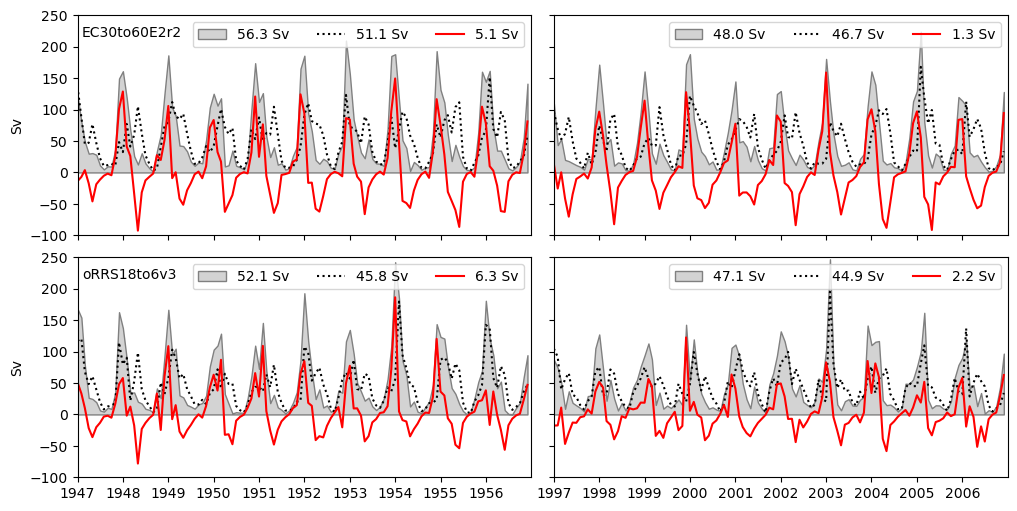

In [143]:
fig, axs = plot_mw_ts('STMW', ylim=[-100, 250])

**SPMW**

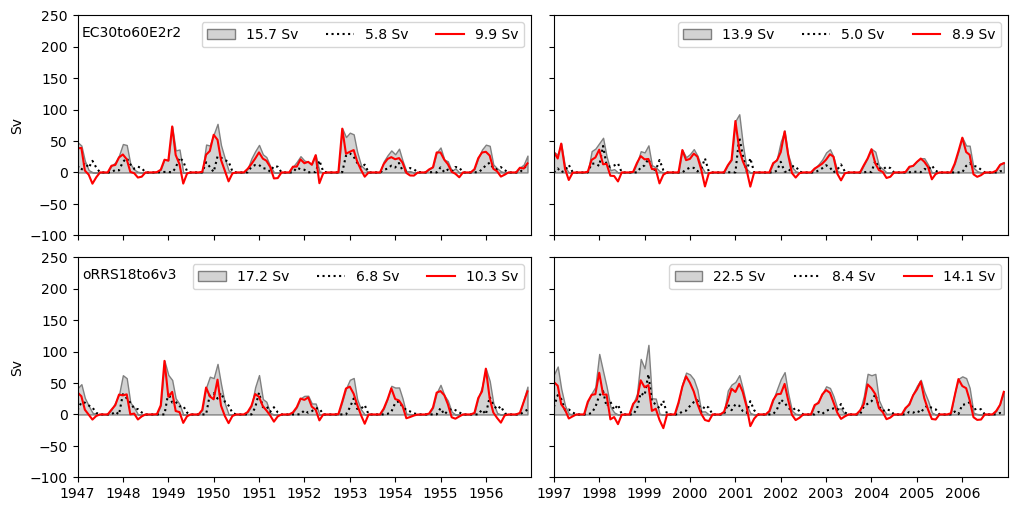

In [144]:
fig, axs = plot_mw_ts('SPMW', ylim=[-100, 250])

***

### Cumulative mode water formation timeseries

**18$^{\circ}$ Water**

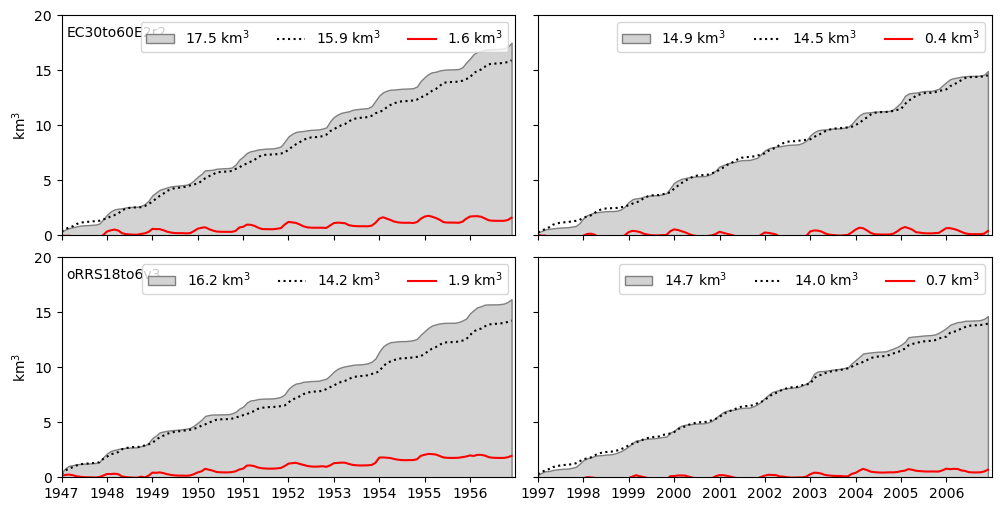

In [155]:
fig, axs = plot_mw_ts('STMW', cumulative=True, ylim=[0, 20])

**SPMW**

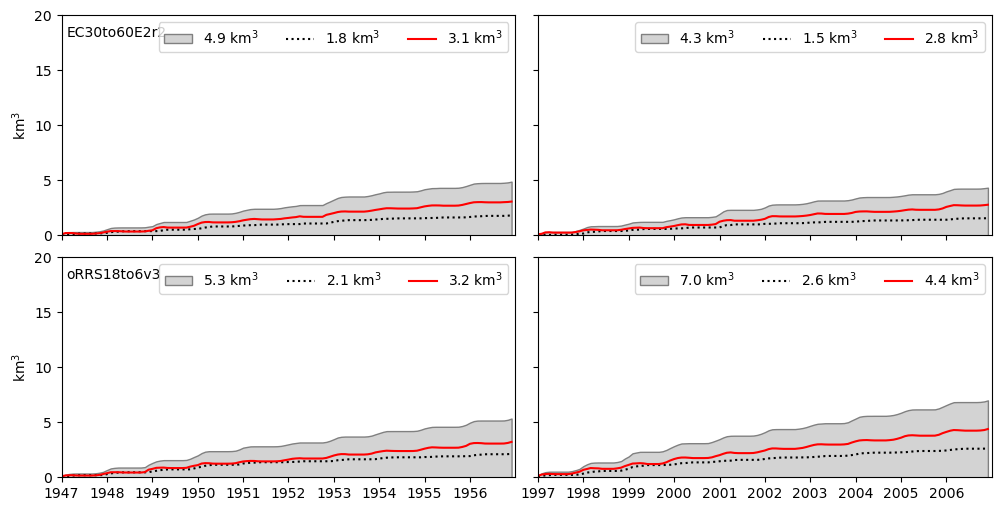

In [156]:
fig, axs = plot_mw_ts('SPMW', cumulative=True, ylim=[0, 20])